# <center> Lecture11 : Evaluating Regression Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

在lec10的末尾，我们引入了是否吸烟这个变量，并建立了一个新的回归模型

在本节课中，我们仍然会使用这个模型，并在该模型上进行扩充

## 模型回顾

首先简单回顾一下对此模型的定义：

* 在这个例子中，我们将是否吸烟作为自变量，将自我控制分数作为因变量

    * 在自变量中，`0` 表示不吸烟，`1`表示吸烟

$$
X_{i2} = \begin{cases}
1 & \text{Yes} \\
0 & \text{No} \\
\end{cases}
$$

* 两种情况下，自我控制分数分布的密度图


![Image Name](https://cdn.kesci.com/upload/s40nk3kagu.png?imageView2/0/w/960/h/960)

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 筛选站点为"Tsinghua"的数据
df_METU = df_raw[df_raw["Site"] == "METU"]

# 选择需要的两列
df_METU = df_METU[["stress","scontrol","smoke"]]

#1 表示吸烟，2表示不吸烟
df_METU["smoke"] =  np.where(df_METU['smoke'] == 2, 0, 1)
df_METU["smoke_recode"] =  np.where(df_METU['smoke'] == 1, "yes", "no")

#设置索引
df_METU["index"] = range(len(df_METU))
df_METU = df_METU.set_index("index")

### 模型定义

* 根据吸烟和自我控制之间的关系建立一个正态回归模型：

$$
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_2 X_{i2}\\
\text{priors:} & & \beta_{0}  &  \sim N\left(60, 2^2\right)  \\
                     & & \beta_1  & \sim N\left(-10, 4^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}

$$

**在这个例子中，各参数的意义：**

* $\beta_0  =  \beta_0 + \beta_2 \cdot 0$

    * 当$X_{i2} = 0$时，$\mu_i$的取值。 $\beta_0 $ 表示不吸烟情况下，自我控制分数的均值

* $\beta_0 + \beta_2 \cdot 1 = \beta_0 + \beta_2 $

    * $\beta_2 $ ：当$X_{i2} = 1$时，$\mu_i$的取值。表示吸烟情况下，自我控制分数的均值，则$\beta_2 $表示了从不吸烟到吸烟，自我控制分数的变化程度

* 这里我们还是根据经验定义先验中的超参

**快速运行模型定义、后验参数采样、后验预测分布部分**

In [3]:
with pm.Model() as category_model:

    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=-10, sigma=4)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")
    mu = pm.Deterministic("mu", beta_0 + beta_1*smoke, dims="obs_id")                           #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [4]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with category_model:
    cat_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 47 seconds.


In [5]:
with category_model:
    cat_ppc = pm.sample_posterior_predictive(cat_regression,
                                             random_seed=84735) 

Sampling: [y_est]


### 评估后验预测

* 这里我们仍然使用上节课介绍过的两个指标：**MAE**与**后验预测区间**。这里不再做具体介绍。

* 这里不再展示具体的代码，简单展示输出的结果

![Image Name](https://cdn.kesci.com/upload/s4behs84tf.PNG?imageView2/0/w/960/h/960)

#### MAE
$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [6]:
from statistics import median
# 计算每个X取值下对应的后验预测模型的均值
cat_pre_x = cat_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
cat_pre_y_mean = cat_pre_x.mean(axis=1).values

# 提取观测值Y，提取对应Y值下的后验预测模型的均值
cat_MAE = pd.DataFrame({
    "scontrol_ppc_mean": cat_pre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
cat_MAE["pre_error"] = cat_MAE["scontrol_original"] -\
                         cat_MAE["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_cat = median(cat_MAE.pre_error)
print(f"计算得到的MAE: {MAE_cat:.2f}")

计算得到的MAE: -1.27


#### 后验预测区间

In [7]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_cat = az.summary(cat_ppc)
hdi_cat = hdi_cat.reset_index()

# 将原数据中的自我控制分数合并，便于后续进行判断
hdi_cat["y_obs"] = cat_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_cat["verify"] = np.where((hdi_cat["y_obs"] >= hdi_cat["hdi_3%"]) & (hdi_cat["y_obs"] <= hdi_cat["hdi_97%"]), 
                  0, 1)
hdi_cat_num = sum(hdi_cat["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_cat_num}")

所有超过后验预测范围HDI的数量: 10


### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

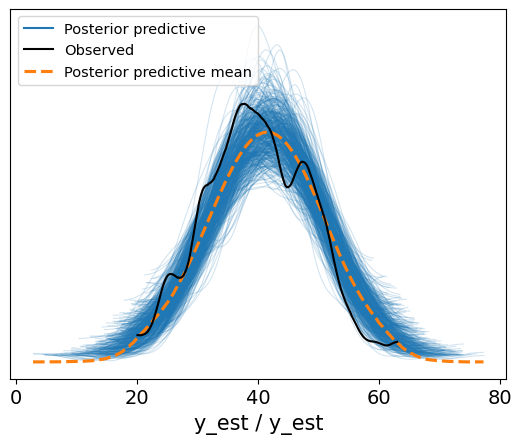

In [8]:
az.plot_ppc(cat_ppc, num_pp_samples=500)

## 增加预测变量

* 我们可以将吸烟情况和压力作为不同的自变量，加入到模型中来

* 基于吸烟情况，绘制原数据中压力和自我控制的关系

![Image Name](https://cdn.kesci.com/upload/s49oqb24we.png?imageView2/0/w/960/h/960)

### 模型定义

$$  
 
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\
\text{priors:} & & \beta_{0}  & \sim N\left(60, 2^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\ 
                    & & \beta_2  & \sim N\left(-10, 4^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  

$$  

**在这个例子中，各参数的意义：**

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 0 = \beta_0 + \beta_1X_{i1}$

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2 \cdot 1 = (\beta_0 + \beta_2) + \beta_1X_{i1}$

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 这里我们还是根据经验定义先验中的超参

**直接运行模型定义、MCMC采样、后验预测部分**

In [9]:
with pm.Model() as multi_linear_model:

    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=-10, sigma=4)
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    stress = pm.MutableData("stress",df_METU.stress, dims="obs_id")                     #x是自变量压力水平
    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*smoke, dims="obs_id")                             #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [10]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with multi_linear_model:
    multi_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 56 seconds.


In [11]:
with multi_linear_model:
    multi_ppc = pm.sample_posterior_predictive(multi_regression,
                                             random_seed=84735) 

Sampling: [y_est]


### 可视化后验预测结果

#### 后验预测的线性模型

我们可以分别查看**吸烟情况**与**压力**对**自我控制**的预测情况

1. $\mu_i = \beta_0 + \beta_1X_{i1}$：自我控制分数随压力分数变化的情况

2. $\mu_i = \beta_0 + \beta_2X_{i2}$：自我控制分数随吸烟变化的情况


In [12]:
# 将参数beta_0, beta_1 与自变量 压力分数 进行组合，生成回归线
multi_regression.posterior["stress_ymodel"] = multi_regression.posterior["beta_0"] +\
                                              multi_regression.posterior["beta_1"] * multi_regression.constant_data["stress"]

# 将参数beta_0, beta_2 与自变量 吸烟情况 进行组合，生成回归线
multi_regression.posterior["smoke_ymodel"] = multi_regression.posterior["beta_0"] +\
                                              multi_regression.posterior["beta_2"] * multi_regression.constant_data["smoke"]

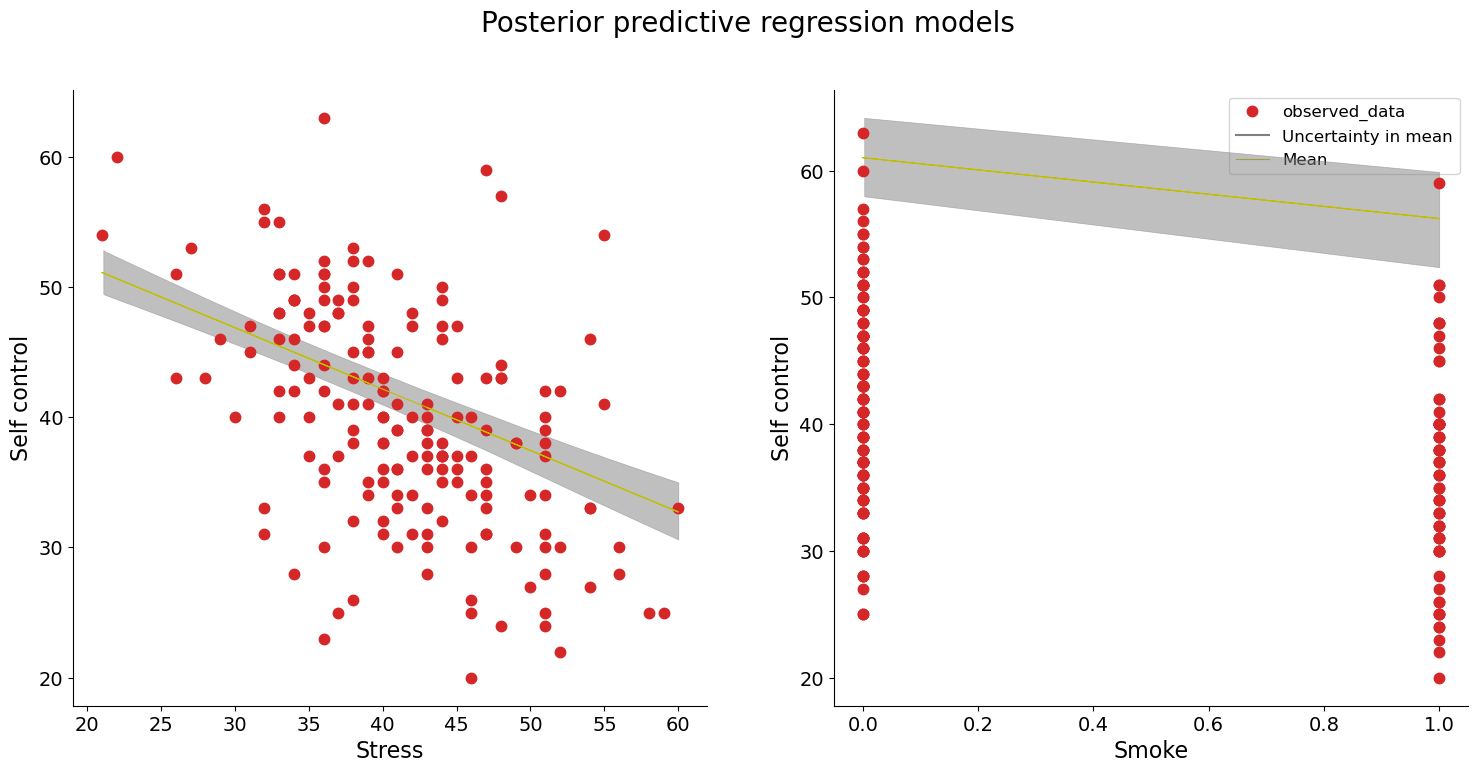

In [13]:
fig, axes = plt.subplots(1,2,figsize=(18, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=multi_regression,
           y= "y_est",
           x= "stress",
           y_model = multi_regression.posterior["stress_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[0],
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})
#设置坐标轴标题
axes[0].set_xlabel('Stress', fontsize=16) 
axes[0].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=multi_regression,
           y= "y_est",
           x= "smoke",
           y_model = multi_regression.posterior["smoke_ymodel"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes[1],
           y_model_fill_kwargs = {"color":"grey"})

#设置坐标轴标题
axes[1].set_xlabel('Smoke', fontsize=16) 
axes[1].set_ylabel('Self control', fontsize=16) 
#----------------------------------------#
# 设置坐标轴字体大小、图例位置、总标题
axes[0].tick_params(labelsize=14)  
axes[1].tick_params(labelsize=14)
axes[1].legend(loc="upper right", fontsize=12)

fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

#### 基于吸烟状况，绘制压力对自我控制影响的回归模型(可自行练习)

In [14]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df_METU.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df_METU.query("smoke == 1")["stress"])["index"].values

In [15]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
nosmoke_para = multi_regression.sel(obs_id=no_smoke_index)
smoke_para = multi_regression.sel(obs_id=smoke_index)

In [16]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
nosmoke_para.posterior["y_model"] = nosmoke_para.posterior["beta_0"] +\
                                    nosmoke_para.posterior["beta_1"] * nosmoke_para.constant_data["stress"] +\
                                    nosmoke_para.posterior["beta_2"] * nosmoke_para.constant_data["smoke"]


In [17]:
# 在吸烟情况下，将参数与自变量进行组合，生成回归线
smoke_para.posterior["y_model"] = smoke_para.posterior["beta_0"] +\
                                  smoke_para.posterior["beta_1"] * smoke_para.constant_data["stress"] +\
                                  smoke_para.posterior["beta_2"] * smoke_para.constant_data["smoke"]


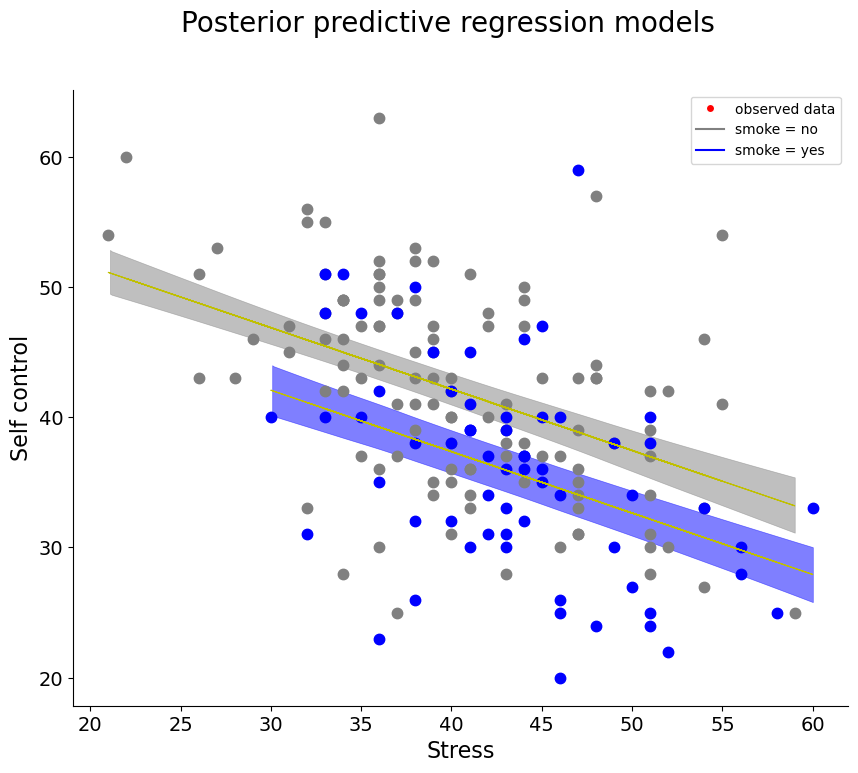

In [40]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=nosmoke_para,
           y= "y_est",
           x= "stress",
           y_model = nosmoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_kwargs = {"color":"grey"},
           y_model_fill_kwargs = {"color":"grey"})

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=smoke_para,
           y= "y_est",
           x= "stress",
           y_model = smoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           y_kwargs = {"color":"blue"},
           y_model_fill_kwargs = {"color":"blue"},
           legend=False)

#设置坐标轴标题
axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Self control', fontsize=16) 

#设置图例
handles = [plt.Line2D([0], [0],
                      marker ='o',
                      color='w', 
                      markerfacecolor='red', 
                      label = 'observed data'),
           plt.Line2D([], [], color="grey",
                      label = 'smoke = no'),
           plt.Line2D([], [], color="blue",
                      label = 'smoke = yes')]

axes.legend(handles=handles)
#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14)  
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

#### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

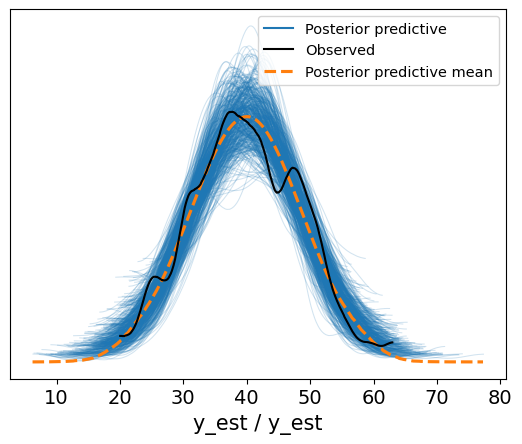

In [19]:
az.plot_ppc(multi_ppc,
            num_pp_samples = 500)

### 评估后验预测

#### MAE

$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [20]:
from statistics import median

# 提取出所有的后验预测值，每一个X对应4*5000个Y的后验预测值，使用stack汇总到一起
multipre_x = multi_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))

#对每一个X，计算其Y的后验预测均值
multipre_y_mean = multipre_x.mean(axis=1).values

# 提取对应的观测值、后验预测均值，存放在一个表格中
multipre_y_mean = pd.DataFrame({
    "scontrol_ppc_mean": multipre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
multipre_y_mean["pre_error"] = multipre_y_mean["scontrol_original"] -\
                                multipre_y_mean["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_multi = median(multipre_y_mean.pre_error)
print(f"计算得到的MAE: {MAE_multi:.2f}")

计算得到的MAE: 0.04


#### 后验预测区间

* 使用`az.summary`，可以直接得到每个Y后验预测值94%的可信区间
* 将真实数据与其合并，判断其是否在对应的94%可信区间内，并进行绘图

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [21]:
az.summary(multi_ppc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_est[0],40.684,7.052,27.695,54.063,0.051,0.036,19382.0,19449.0,1.0
y_est[1],34.989,7.176,21.288,48.112,0.052,0.037,19316.0,19029.0,1.0
y_est[2],42.129,7.102,28.585,55.421,0.050,0.035,20364.0,19440.0,1.0
y_est[3],38.306,7.110,24.650,51.474,0.051,0.036,19445.0,19219.0,1.0
y_est[4],43.978,7.112,30.366,57.139,0.050,0.035,20292.0,20110.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[176],38.912,7.083,26.103,52.787,0.051,0.036,19157.0,20143.0,1.0
y_est[177],43.182,7.046,29.954,56.526,0.050,0.036,19700.0,19449.0,1.0
y_est[178],40.705,7.138,27.281,54.041,0.051,0.036,19399.0,19599.0,1.0
y_est[179],38.932,7.067,25.449,51.869,0.050,0.036,19787.0,19573.0,1.0


In [22]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_multi = az.summary(multi_ppc)
hdi_multi = hdi_multi.reset_index()

# 将原数据中的压力分数与自我控制分数合并，便于后续进行判断
hdi_multi["x_obs"] = multi_ppc.constant_data["stress"].values
hdi_multi["y_obs"] = multi_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_multi["verify"] = np.where((hdi_multi["y_obs"] >= hdi_multi["hdi_3%"]) & (hdi_multi["y_obs"] <= hdi_multi["hdi_97%"]), 
                  0, 1)
hdi_multi_num = sum(hdi_multi["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_multi_num}")

所有超过后验预测范围HDI的数量: 9


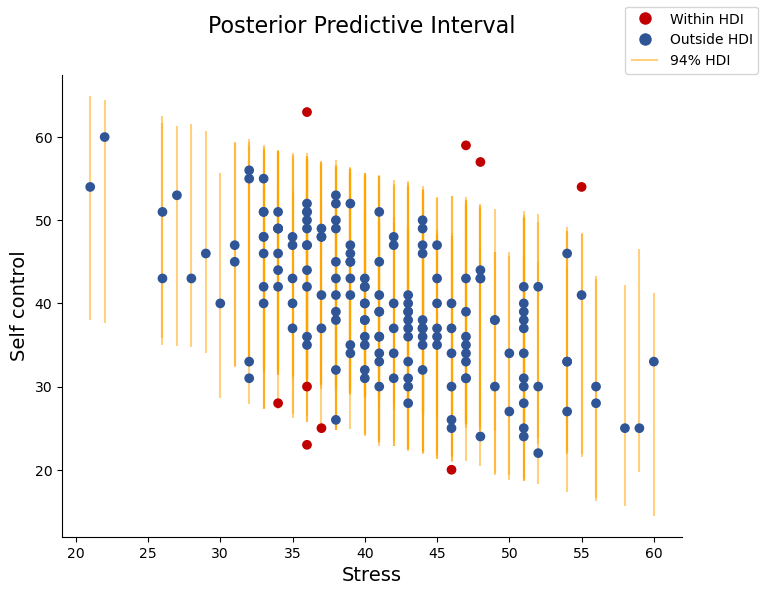

In [41]:
fig, ax =  plt.subplots(figsize=(8,6))

# 绘制94%的可信区间
HDI = ax.vlines(hdi_multi["x_obs"], 
          hdi_multi["hdi_3%"], hdi_multi["hdi_97%"], 
          color="orange", 
          alpha=0.5,
          label="94% HDI")

#绘制真实值的散点图，并根据是否落在区间内设置观测值的不同颜色
colors = np.where((hdi_multi["y_obs"] >= hdi_multi["hdi_3%"]) & (hdi_multi["y_obs"] <= hdi_multi["hdi_97%"]), 
                  '#2F5597','#C00000')
ax.scatter(hdi_multi["x_obs"], hdi_multi["y_obs"],
           c = colors,
           zorder = 2)

# 设置图例的颜色、形状、名称
legend_color = ['#C00000','#2F5597']
handles = [plt.Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor=color, markersize=10) for color in legend_color]
handles += [HDI]
labels = ['Within HDI', 'Outside HDI','94% HDI']

# 设置坐标轴名称、标题
ax.set_xlabel('Stress', fontsize=14) 
ax.set_ylabel('Self control', fontsize=14)
fig.legend(handles=handles, labels=labels, loc='outside upper right')
fig.suptitle('Posterior Predictive Interval', fontsize=16)
sns.despine()


## 增加交互项

* **交互作用：** 存在两个或两个以上自变量时，其中，自变量$X_1$对因变量$Y$的影响在自变量$X_2$的不同水平上有所差异
    
    * 在本例中，我们可以假设，在不同的吸烟状况下，压力对自我控制的影响略有不同(体现在斜率上) 

![Image Name](https://cdn.kesci.com/upload/s4baxp7vsh.png?imageView2/0/w/960/h/960)

那么我们可以加入交互项：$\mu = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{1}X_{2}  $

$$
\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1}X_{i2} \\
\text{priors:} & & \beta_{0c}  &  \sim N\left(60, 2^2 \right)  \\
                     & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\
                     & & \beta_2  & \sim N\left(-10, 4^2 \right) \\
                     & & \beta_3  & \sim N\left(0, 0.8^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}
\end{equation}
$$

**在这个例子中，各参数的意义：**

* 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$

    * 表示不吸烟情况下，自我控制分数随压力分数变化的情况，二者的关系可以被简化为一条直线。

* 当$X_{i2} = 1$时，$\mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} + \beta_3X_{i1} = (\beta_0 +\beta_2) + (\beta_1 + \beta_3)X_{i1}$

    * 表示吸烟情况下，自我控制分数随压力分数变化的情况
    * 注意截距项和斜率项的变化
    * 此时压力对自我控制的影响为$(\beta_1 + \beta_3)$，体现了吸烟对这一关系的影响

* 这里我们还是根据经验定义先验中的超参

**直接运行模型定义、MCMC采样、后验预测部分**

In [24]:
with pm.Model() as interaction_model:
    beta_0 = pm.Normal("beta_0", mu=60, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=-10, sigma=4)         #定义beta_2
    beta_3 = pm.Normal("beta_3", mu=0, sigma=0.8)         #定义beta_3
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    stress = pm.MutableData("stress",df_METU.stress, dims="obs_id")      #stress是自变量压力水平
    smoke = pm.MutableData("smoke",df_METU.smoke, dims="obs_id")         #smoke是自变量吸烟水平
    mu = pm.Deterministic("mu", beta_0 + 
                                beta_1*stress + 
                                beta_2*smoke +
                                beta_3*stress*smoke, dims="obs_id")      #定义mu，将自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol, dims="obs_id")   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                                    #通过 observed 传入实际数据y 自我控制水平

In [25]:
with interaction_model:
    interaction_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                       tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                       chains=4,                     # 链数
                                       discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                       random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 78 seconds.


In [26]:
with interaction_model:
    interaction_ppc = pm.sample_posterior_predictive(interaction_regression,
                                                     random_seed=84735)

Sampling: [y_est]


### 可视化后验预测结果

#### 后验预测的线性模型

我们可以分别查看不同吸烟情况下，压力对自我控制的预测情况

1. 当$X_{i2} = 0$时，$\mu_i = \beta_0 + \beta_1X_{i1}$：不吸烟情况下，自我控制分数随压力分数变化的情况

2. 当$X_{i2} = 1$时，$\mu_i = (\beta_0 +  \beta_2) + (\beta_1 + \beta_3)X_{i1}$：吸烟情况下，自我控制分数随压力分数变化的情况

* 根据吸烟情况($X_{i2} = 0/1$)，将后验参数的预测值分成两部分

* 代入公式，$\mu = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i1}X_{i2}$，获得对应的后验预测均值



In [27]:
# 分别获取smoke=0及smoke=1时，压力变量对应的索引值
no_smoke_index = xr.DataArray(df_METU.query("smoke == 0")["stress"])["index"].values
smoke_index = xr.DataArray(df_METU.query("smoke == 1")["stress"])["index"].values

In [28]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
in_nosmoke_para = interaction_regression.sel(obs_id=no_smoke_index)
in_smoke_para = interaction_regression.sel(obs_id=smoke_index)

* 查看 `in_nosmoke_para`:`constant_data`中的`smoke`值全为0，表明已经根据吸烟情况将后验预测数据分成了两份

In [29]:
in_nosmoke_para

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [30]:
# 在不吸烟情况下，将参数与自变量进行组合，生成回归线
in_nosmoke_para.posterior["y_model"] = in_nosmoke_para.posterior["beta_0"] +\
                                    in_nosmoke_para.posterior["beta_1"] * in_nosmoke_para.constant_data["stress"] +\
                                    in_nosmoke_para.posterior["beta_2"] * in_nosmoke_para.constant_data["smoke"] +\
                                    in_nosmoke_para.posterior["beta_3"] * in_nosmoke_para.constant_data["smoke"] * in_nosmoke_para.constant_data["stress"]


In [31]:
# 在吸烟情况下，将参数与自变量进行组合，生成回归线
in_smoke_para.posterior["y_model"] = in_smoke_para.posterior["beta_0"] +\
                                    in_smoke_para.posterior["beta_1"] * in_smoke_para.constant_data["stress"] +\
                                    in_smoke_para.posterior["beta_2"] * in_smoke_para.constant_data["smoke"] +\
                                    in_smoke_para.posterior["beta_3"] * in_smoke_para.constant_data["smoke"] * in_smoke_para.constant_data["stress"]


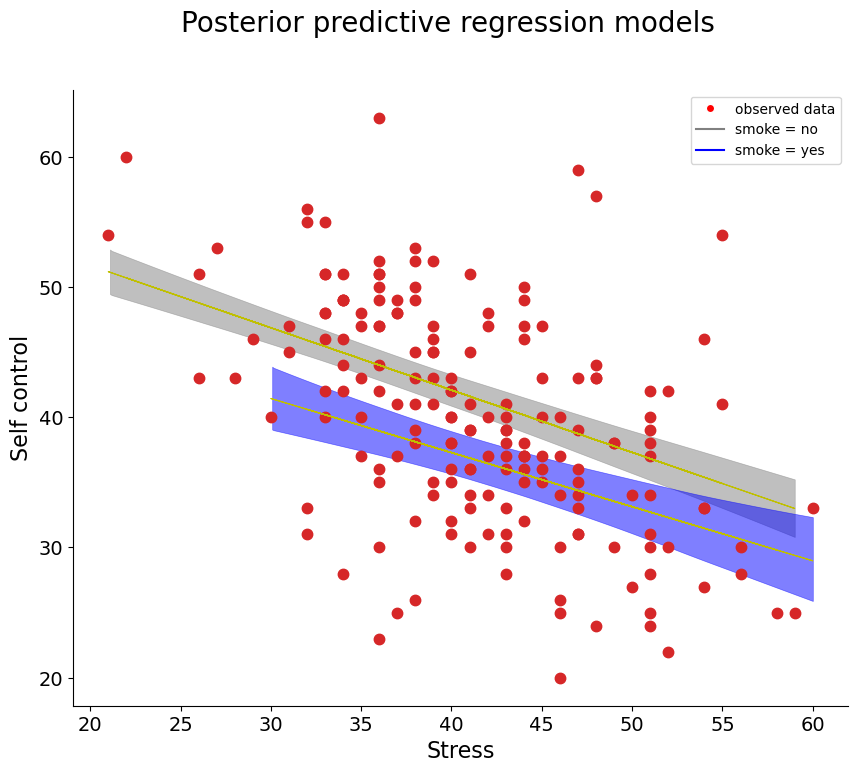

In [32]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=in_nosmoke_para,
           y= "y_est",
           x= "stress",
           y_model = in_nosmoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_model_fill_kwargs = {"color":"grey"})

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=in_smoke_para,
           y= "y_est",
           x= "stress",
           y_model = in_smoke_para.posterior["y_model"],
           kind_model = "hdi",
           textsize=15,
           grid=False,
           axes=axes,
           legend=False,
           y_model_fill_kwargs = {"color":"blue"})

#设置标题、坐标轴标题

axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Self control', fontsize=16) 

#设置图例
handles = [plt.Line2D([0], [0],
                      marker ='o',
                      color='w', 
                      markerfacecolor='red', 
                      label = 'observed data'),
           plt.Line2D([], [], color="grey",
                      label = 'smoke = no'),
           plt.Line2D([], [], color="blue",
                      label = 'smoke = yes')]

axes.legend(handles=handles)

#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14) 
 
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

* 我们可以将有交互项和无交互项两种模型生成的回归线进行对比：

![Image Name](https://cdn.kesci.com/upload/s4b4rk25wv.png?imageView2/0/w/960/h/960)


#### 后验预测分布

* 通过pymc，绘制当前模型对自我控制分数的后验预测分布

<Axes: xlabel='y_est / y_est'>

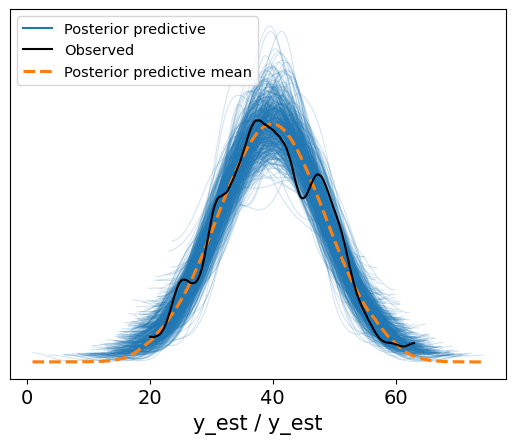

In [33]:
az.plot_ppc(interaction_ppc, num_pp_samples=500)

### 评估后验预测

#### MAE

$$
\text{MAE} = median\left(|Y_i - \hat{Y}_i|\right)
$$

In [34]:
from statistics import median

# 提取出所有的后验预测值，每一个X对应4*5000个Y的后验预测值，使用stack汇总到一起
interpre_x = interaction_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))

#对每一个X，计算其Y的后验预测均值
interpre_y_mean = interpre_x.mean(axis=1).values

# 提取对应的观测值、后验预测均值，存放在一个表格中
interpre_y_mean = pd.DataFrame({
    "scontrol_ppc_mean": interpre_y_mean,
    "scontrol_original": df_METU.scontrol
})

# 计算预测误差
interpre_y_mean["pre_error"] = interpre_y_mean["scontrol_original"] -\
                                interpre_y_mean["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE_interaction = median(interpre_y_mean.pre_error)
print(f"计算得到的MAE: {MAE_interaction:.2f}")

计算得到的MAE: 0.17


#### 后验预测区间

* 使用`az.summary`，可以直接得到每个Y后验预测值94%的可信区间
* 将真实数据与其合并，判断其是否在对应的94%可信区间内，并进行绘图

> 注意：在真实数据中，一个X可能对应着多个Y，因此可信区间在绘制时会出现重叠

In [35]:
az.summary(interaction_ppc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_est[0],40.591,7.059,27.203,53.602,0.051,0.036,19441.0,19722.0,1.0
y_est[1],35.198,7.188,22.300,49.232,0.052,0.037,19247.0,19298.0,1.0
y_est[2],42.053,7.107,28.469,55.275,0.050,0.035,20389.0,19505.0,1.0
y_est[3],38.175,7.132,24.579,51.454,0.051,0.036,19475.0,18802.0,1.0
y_est[4],43.934,7.121,30.622,57.391,0.050,0.035,20368.0,20100.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[176],38.786,7.098,24.868,51.601,0.051,0.036,19117.0,19973.0,1.0
y_est[177],43.119,7.058,30.470,57.127,0.050,0.036,19713.0,19639.0,1.0
y_est[178],40.604,7.146,27.346,54.178,0.050,0.036,20068.0,19683.0,1.0
y_est[179],38.811,7.096,25.062,51.692,0.050,0.036,19821.0,19416.0,1.0


In [36]:
# 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
hdi_interaction = az.summary(interaction_ppc)
hdi_interaction = hdi_interaction.reset_index()

# 将原数据中的压力分数与自我控制分数合并，便于后续进行判断
hdi_interaction["x_obs"] = interaction_ppc.constant_data["stress"].values
hdi_interaction["y_obs"] = interaction_ppc.observed_data["y_est"].values

# 判断原数据中的压力分数是否在后验预测的94%可信区间内，并计数
hdi_interaction["verify"] = np.where((hdi_interaction["y_obs"] >= hdi_interaction["hdi_3%"]) & (hdi_interaction["y_obs"] <= hdi_multi["hdi_97%"]), 
                  0, 1)
hdi_interaction_num = sum(hdi_interaction["verify"])
print(f"所有超过后验预测范围HDI的数量: {hdi_interaction_num}")

所有超过后验预测范围HDI的数量: 9


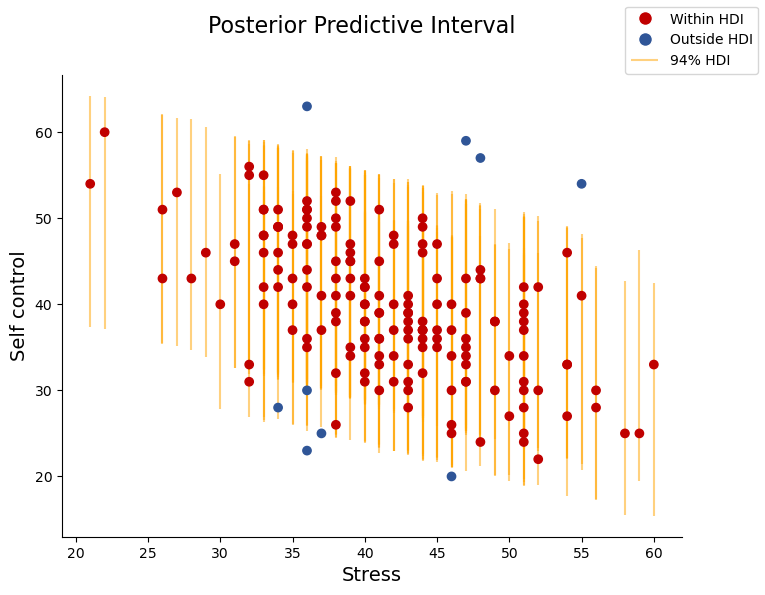

In [37]:
fig, ax =  plt.subplots(figsize=(8,6))

# 绘制94%的可信区间
HDI = ax.vlines(hdi_interaction["x_obs"], 
          hdi_interaction["hdi_3%"], hdi_interaction["hdi_97%"], 
          color="orange", 
          alpha=0.5,
          label="94% HDI")

#绘制真实值的散点图，并根据是否落在区间内设置观测值的不同颜色
colors = np.where((hdi_interaction["y_obs"] >= hdi_interaction["hdi_3%"]) & (hdi_interaction["y_obs"] <= hdi_multi["hdi_97%"]), 
                  '#C00000', '#2F5597')
ax.scatter(hdi_interaction["x_obs"], hdi_interaction["y_obs"],
           c = colors,
           zorder = 2)

# 设置图例的颜色、形状、名称
legend_color = ['#C00000','#2F5597']
handles = [plt.Line2D([0], [0], 
                      marker='o', 
                      color='w', 
                      markerfacecolor=color, markersize=10) for color in legend_color]
handles += [HDI]
labels = ['Within HDI', 'Outside HDI','94% HDI']

# 设置坐标轴名称、标题
ax.set_xlabel('Stress', fontsize=14) 
ax.set_ylabel('Self control', fontsize=14)
fig.legend(handles=handles, labels=labels, loc='outside upper right')
fig.suptitle('Posterior Predictive Interval', fontsize=16)
sns.despine()


## 总结模型后验预测表现情况

In [38]:
summary_MAE_interval = pd.DataFrame({"model_name":["category_model","multi_linear_model","interaction_model"],
                                    "MAE":[MAE_cat,MAE_multi,MAE_interaction],
                                    "HDI_num":[hdi_cat_num,hdi_multi_num,hdi_interaction_num]})

summary_MAE_interval 

,model_name,MAE,HDI_num
0,category_model,-1.268343,10
1,multi_linear_model,0.042424,9
2,interaction_model,0.166760,9
